## Compare the functions of dissimilarity on basic stacking models

### Libraries importation

In [ ]:
import time
import os
import math
import csv
import importlib
from pathlib import Path
import numpy as np
import pinard as pn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

from pinard import utils
from pinard import preprocessing as pp

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from xgboost import XGBRegressor
from itertools import combinations
from dissimilarity_functions import *


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

### Importation of the datasets

In [4]:
# Function to load a CSV file with automatic separator detection

def load_csv_auto_sep(mode, data_source, type_data, verbose=True):
 
     # Regression: 'BeerOriginalExtract' or 'Digest_0.8' or 'YamProtein' //
    # Classification: 'CoffeeSpecies' or 'Malaria2024' or 'mDigest_custom3' or 'WhiskyConcentration' or 'YamMould'

    ## Importation of the datasets with the adapted path
    file_name = Path("Data/%s/%s"% (mode,data_source))
    full_path = str(file_name.resolve()).replace("\\", "/")
    path = full_path + "/%s.csv" % type_data

    with open(path, 'r', newline='', encoding='utf-8') as f:
        # Read a small portion of the file to detect the separator
        excerpt = f.read(1024)
        f.seek(0)  # return to the beginning of the file

        # Detection of the dialect
        dialect = csv.Sniffer().sniff(excerpt)
        sep = dialect.delimiter

        if verbose: print("Detected separator : %s" % sep)
        
        # Load the file with pandas
        df = pd.read_csv(f, delimiter=sep)

        if len(df.columns) > 1:
            # Drop the useless column if it exists
            df = df.drop(columns=[df.columns[1]])
        
        return df

In [5]:
mode = 'Regression'
data_source = 'BeerOriginalExtract'

Xcal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xcal')
Xval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xval')
Ycal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Ycal')
Yval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Yval')

print("Number of spectra for calibration: ", len(Ycal))
print("Number of spectra for test: ", len(Yval))
display(Xcal.head(5))

Detected separator : ;
Detected separator : ;
Detected separator : 
Detected separator : 
Number of spectra for calibration:  40
Number of spectra for test:  20


,V1,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V567,V568,V569,V570,V571,V572,V573,V574,V575,V576
0,0.245288,0.258437,0.265449,0.272342,0.280249,0.288323,0.297118,0.307861,0.319456,0.333941,...,3.679895,3.654557,3.653983,3.714209,3.669642,3.625521,3.647152,3.573585,3.623088,3.679775
1,0.242613,0.255609,0.262486,0.269311,0.277092,0.285063,0.293715,0.304371,0.315839,0.330161,...,3.632740,3.738945,3.601677,3.592955,3.606268,3.657218,3.632019,3.660901,3.635919,3.671539
2,0.241651,0.254431,0.261214,0.267891,0.275535,0.283370,0.291886,0.302335,0.313625,0.327746,...,3.563812,3.622122,3.617598,3.652315,3.590150,3.710362,3.630672,3.653063,3.566837,3.704355
3,0.239650,0.252350,0.259107,0.265761,0.273390,0.281214,0.289725,0.300164,0.311455,0.325609,...,3.583575,3.620621,3.682378,3.681044,3.650404,3.645983,3.633222,3.668727,3.650432,3.687260
4,0.240787,0.253521,0.260278,0.266935,0.274576,0.282420,0.290953,0.301394,0.312720,0.326881,...,3.650906,3.728940,3.614735,3.618842,3.656746,3.622961,3.560679,3.710902,3.653769,3.663029


In [46]:
rd_seed = 42
rd_seed = np.random.seed(rd_seed)

x = pd.concat([Xcal, Xval], axis=0).values
y = pd.concat([Ycal, Yval], axis=0).values

### Selection of the preprocessing methods

In [47]:
# Dictionnary of preprocessing methods that we want to apply

preprocessings = {
    'Savitzky-Golay (0)': pp.SavitzkyGolay(),
    'Savitzky-Golay (1)': pp.SavitzkyGolay(deriv=1),
    'Savitzky-Golay (2)': pp.SavitzkyGolay(deriv=2),
    'Savitzky-Golay (3)': pp.SavitzkyGolay(deriv=3),
    'Savitzky-Golay (4)': pp.SavitzkyGolay(deriv=4),
    'Savitzky-Golay (5)': pp.SavitzkyGolay(deriv=5),
    'Savitzky-Golay (6)': pp.SavitzkyGolay(deriv=6),
    'Gaussian (1, 2)': pp.Gaussian(order = 1, sigma = 2),
    'Gaussian (2, 1)': pp.Gaussian(order = 2, sigma = 1),
    'Gaussian (3, 1)': pp.Gaussian(order = 3, sigma = 1),
    'Gaussian (4, 1)': pp.Gaussian(order = 4, sigma = 1),
    'Gaussian (5, 1)': pp.Gaussian(order = 5, sigma = 1)
}

### Remove the preprocessing methods in an optimal way

We want to remove preprocessing methods so that it keeps the maximum possible number of them, still respecting the comparison obtained with the dissimilarity function.  

It actually is a classic problem in graph theory: the **minimum vertex cover problem** on an undirected graph, specifically where each pair represents an edge.

- Each preprocessing method is a **node**,
- Each couple is an **edge** between two nodes,
- We aim to find a minimum vertex cover, i.e. a set of nodes that every edge is incident to at least one node in the set.

For a bipartite graph, there are efficient algorithms to solve this optimally, for instance in the *networkx* package. It gives an **approximation of the optimal solution** but is still very close from optimal or optimal. To get the exact solution, one needs using linear programming, which might be computationnally heavy.

In [48]:
dissim = importlib.import_module('dissimilarity_functions')
importlib.reload(dissim)

list_KS = dissim.preprocessings_to_remove_approx(preprocessings, x, distance_fn=dissim.dissim_KS, normalize_dissim=False, threshold=("proportion", 0.1))
list_meta = dissim.preprocessings_to_remove_approx(preprocessings, x, distance_fn=dissim.dissim_meta_att_var, normalize_dissim=True, threshold=("proportion", 0.1))


print("List of preprocessing methods to remove for KS dissimilarity:", list_KS)
print("-"*150)
print("List of preprocessing methods to remove for meta attributes dissimilarity:", list_meta)


# Remove it from the preprocessing methods
for i in list_KS:
    del preprocessings[i]

List of preprocessing methods to remove for KS dissimilarity: {'Gaussian (3, 1)', 'Gaussian (2, 1)', 'Savitzky-Golay (1)', 'Savitzky-Golay (5)', 'Savitzky-Golay (4)', 'Savitzky-Golay (2)'}
------------------------------------------------------------------------------------------------------------------------------------------------------
List of preprocessing methods to remove for meta attributes dissimilarity: {'Savitzky-Golay (4)', 'Savitzky-Golay (0)', 'Savitzky-Golay (5)'}


### Creation of a pipeline for a stacking model

In [49]:
# create a pipeline that applies min-max scaling followed by preprocessing
union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessings))

# this function creates a pipeline that applies the union_pipeline followed by the regressor
def get_estimator(regressor):
    pipeline = make_pipeline(union_pipeline, regressor)
    return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

# create a list of estimators to use in the stacking regressor, each one is a pipeline of the union_pipeline and a regressor
estimators = [
    ("Linear Regression", get_estimator( LinearRegression() ) ),
    ("PLS", get_estimator( PLSRegression(n_components=10) ) ),
    ("PLS_small", get_estimator( PLSRegression(n_components=3) ) ),
    ("XGBoost", get_estimator( XGBRegressor() ) )
]

# create the stacking regressor, using the list of estimators and a final regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=rd_seed))

### Predict and show the results

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ValueError: too many values to unpack (expected 2)

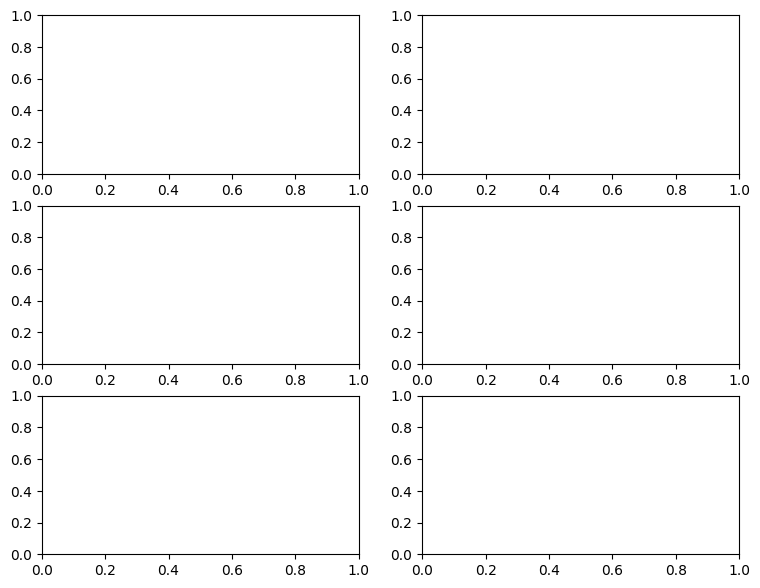

In [51]:
# function to plot a scatter plot of the predicted vs true targets,
# along with the scores and elapsed time of the model
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    # plot the line y=x for reference
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    # formatting the plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(3, 2, figsize=(9, 7))
axs = np.ravel(axs)

# looping through estimators and the stacking regressor
for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    
    if name == "Stacking Regressor":
        start_time = time.time()
        # using cross_validate to get scores and elapsed time
        score = cross_validate(est, x, y, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2)
        elapsed_time = time.time() - start_time

    # using cross_val_predict to get predicted values
    y_pred = cross_val_predict(est, x, y, cv=4, n_jobs=2, verbose=1)

    # call the plot_regression_results function
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

# add subtitle and show the scatter plot
plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [56]:
y.shape

(60, 1)